In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#Existing Models

In [ ]:
import pandas as pd

# Create dictionary with the data
data = {
    'Model': [
        'Random Forest', 'Random Forest 2', 'Extra Trees', 'Extra Trees 2',
        'SVM', 'KNN', 'XGBoost', 'MLP', 'CRF'
    ],
    'Average Precision': [0.64, 0.40, 0.59, 0.43, 0.54, 0.59, 0.48, 0.48, 0.56],
    'Average Recall': [0.52, 0.46, 0.55, 0.50, 0.56, 0.56, 0.50, 0.51, 0.58],
    'Average F1-Score': [0.52, 0.41, 0.55, 0.45, 0.54, 0.55, 0.48, 0.49, 0.56]
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('model_metrics.csv', index=False)

# Display the DataFrame to verify
print(df)

             Model  Average Precision  Average Recall  Average F1-Score
0    Random Forest               0.64            0.52              0.52
1  Random Forest 2               0.40            0.46              0.41
2      Extra Trees               0.59            0.55              0.55
3    Extra Trees 2               0.43            0.50              0.45
4              SVM               0.54            0.56              0.54
5              KNN               0.59            0.56              0.55
6          XGBoost               0.48            0.50              0.48
7              MLP               0.48            0.51              0.49
8              CRF               0.56            0.58              0.56


#New Models

In [5]:
file_path = '/content/data_labelled.csv'
data = pd.read_csv(file_path)

coordinate_columns = ['nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
                      'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
                      'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

for col in coordinate_columns:
    data[col] = data[col].apply(lambda x: np.array(eval(x), dtype=float))

###GCN

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

!pip install torch-scatter -f https://data.pyg.org/whl/torch-<torch_version>+<cuda_version>.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-<torch_version>+<cuda_version>.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-<torch_version>+<cuda_version>.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-<torch_version>+<cuda_version>.html

!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
/bin/bash: line 1: torch_version: No such file or directory
/bin/bash: line 1: torch_version: No such file or directory
/bin/bash: line 1: torch_version: No such file or directory
/bin/bash: line 1: torch_version: No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import openpyxl
from sklearn.model_selection import ParameterSampler

In [ ]:
X = data[coordinate_columns]  # Extract landmark coordinates
y = data['pose']  # Assuming 'pose' is the target column

# Encode target labels as integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

class_counts = y.value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(label_mapping))], dtype=torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0]], dtype=torch.long)


In [ ]:
def create_graph_data(data, labels):
    graph_data_list = []
    for idx, row in data.iterrows():
        x = torch.tensor([row[col] for col in coordinate_columns], dtype=torch.float).view(-1, 2)
        y = torch.tensor([labels.loc[row.name]] * x.size(0), dtype=torch.long)  # Assign label to each node
        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graph_data_list.append(graph_data)
    return graph_data_list

In [ ]:
train_graphs = create_graph_data(X_train, y_train)
test_graphs = create_graph_data(X_test, y_test)
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
param_grid = {
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1],
    'weight_decay': [0, 1e-4, 5e-4, 1e-3, 1e-2],
    'hidden_dim': [16, 32, 64, 128],
    'num_layers': [2, 3, 4],
    'batch_size': [8, 16, 32]
}

In [ ]:
n_iter = 10  # Number of iterations for Randomized Search
param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim, num_layers):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.convs[-1](x, edge_index)
        return x

In [ ]:
def train_and_evaluate(params):
    batch_size = params['batch_size']
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

    model = GCN(num_node_features=2, num_classes=len(label_mapping),
                hidden_dim=params['hidden_dim'], num_layers=params['num_layers'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 101):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

    accuracy, f1, _, _ = test(test_loader)
    return accuracy, f1

In [ ]:
besst_params = None
best_f1 = 0
results = []

In [ ]:
for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    accuracy, f1 = train_and_evaluate(params)
    results.append((params, accuracy, f1))
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

Hyperparameter Tuning:  10%|█         | 1/10 [00:21<03:10, 21.14s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Hyperparameter Tuning:  20%|██        | 2/10 [00:26<01:35, 11.95s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Hyperparameter Tuning:  30%|███       | 3/10 [00:54<02:14, 19.27s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Hyperparameter Tuning:  40%|████      | 4/10 [01:03<01:31, 15.26s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Hyperparameter Tuning:  50%|

In [ ]:
# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)

Best Hyperparameters: {'weight_decay': 0, 'num_layers': 4, 'lr': 0.1, 'hidden_dim': 16, 'batch_size': 8}
Best F1 Score: 0.0789466087701058


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=16, num_layers=4):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, num_classes))
        self.dropout = torch.nn.Dropout(p=0.5)  # Add dropout layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)  # Apply dropout after each layer except the last
        x = self.convs[-1](x, edge_index)
        return x  # Output logits for each node

In [ ]:
num_node_features = 2  # x and y coordinates
num_classes = len(label_mapping)
hidden_dim = 32
num_layers = 3
model = GCN(num_node_features, num_classes, hidden_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Reduced learning rate to 0.001, added weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Use weighted loss

In [ ]:
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)  # Output and target should match in shape
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
        optimizer.step()
    scheduler.step()

In [ ]:
def test(loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_nodes
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())
    accuracy = correct / total
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1, y_true, y_pred

In [ ]:
metrics = []  # To store metrics for each epoch
for epoch in range(1, 201):
    train()
    if epoch % 10 == 0:
        accuracy, f1, y_true, y_pred = test(test_loader)
        print(f"Epoch: {epoch}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
        metrics.append((epoch, accuracy, f1))

Epoch: 10, Test Accuracy: 0.3614, F1 Score: 0.1919
Epoch: 20, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 30, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 40, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 50, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 60, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 70, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 80, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 90, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 100, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 110, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 120, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 130, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 140, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 150, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 160, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 170, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 180, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 190, Test Accuracy: 0.1325, F1 Score: 0.0310
Epoch: 200, Test Accu

In [ ]:
# Final evaluation and confusion matrix
test_accuracy, test_f1, y_true, y_pred = test(test_loader)
print("Final Test Accuracy:", test_accuracy)
print("Final F1 Score:", test_f1)
print("Classification Report:\n", classification_report(y_true, y_pred))
metrics.append(('Final', test_accuracy, test_f1))

Final Test Accuracy: 0.3614457831325301
Final F1 Score: 0.19191811493762662
Classification Report:
               precision    recall  f1-score   support

           0       0.36      1.00      0.53       390
           1       0.00      0.00      0.00       208
           2       0.00      0.00      0.00        91
           3       0.00      0.00      0.00       143
           4       0.00      0.00      0.00       247

    accuracy                           0.36      1079
   macro avg       0.07      0.20      0.11      1079
weighted avg       0.13      0.36      0.19      1079



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


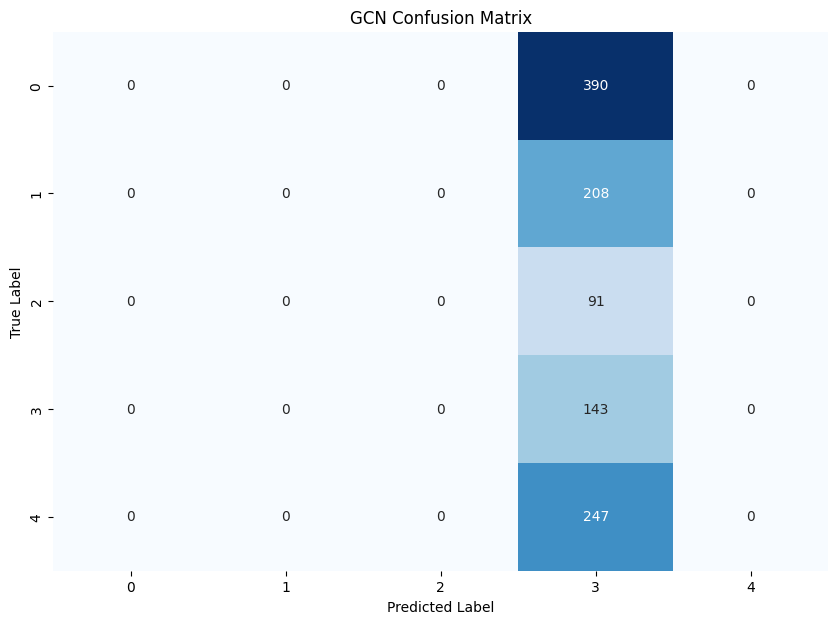

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('GCN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

###TPOT

In [56]:
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.3 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=03e9751de2624e7c632f6f62865862347a185e084c4ec8423d85ee862bc67e1c
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [84]:
def extract_coordinates(row):
    x_coords = []
    y_coords = []
    for col in coordinate_columns:
        coord = eval(row[col]) if isinstance(row[col], str) else row[col]
        if isinstance(coord, (list, np.ndarray)) and len(coord) == 2:
            x_coords.append(coord[0])
            y_coords.append(coord[1])
    return pd.Series(x_coords + y_coords)

In [85]:
expanded_data = data.apply(extract_coordinates, axis=1)
expanded_data.columns = [f'{col}_{axis}' for col in coordinate_columns for axis in ['x', 'y']]

# Drop rows with missing values if any were introduced during coordinate extraction
expanded_data.dropna(inplace=True)

In [86]:
y = data.loc[expanded_data.index, 'pose']  # Ensure target is aligned with the filtered features

# Encode target labels as integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(expanded_data, y, test_size=0.2, random_state=42)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(expanded_data, y, test_size=0.2, random_state=42)

In [88]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=42, verbosity=2)

In [89]:
pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.582858435097241

Generation 2 - Current best internal CV score: 0.5951153324287652

Generation 3 - Current best internal CV score: 0.5951153324287652

Generation 4 - Current best internal CV score: 0.6041157847127996

Generation 5 - Current best internal CV score: 0.6161917684305743

Best pipeline: RandomForestClassifier(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.55, min_samples_leaf=2, min_samples_split=8, n_estimators=100), bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=12, min_samples_split=13, n_estimators=100)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

In [90]:
y_pred = pipeline_optimizer.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


In [91]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.5542168674698795
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.50      0.56        30
           1       0.46      0.38      0.41        16
           2       0.67      0.29      0.40         7
           3       0.44      0.64      0.52        11
           4       0.59      0.84      0.70        19

    accuracy                           0.55        83
   macro avg       0.56      0.53      0.52        83
weighted avg       0.56      0.55      0.54        83



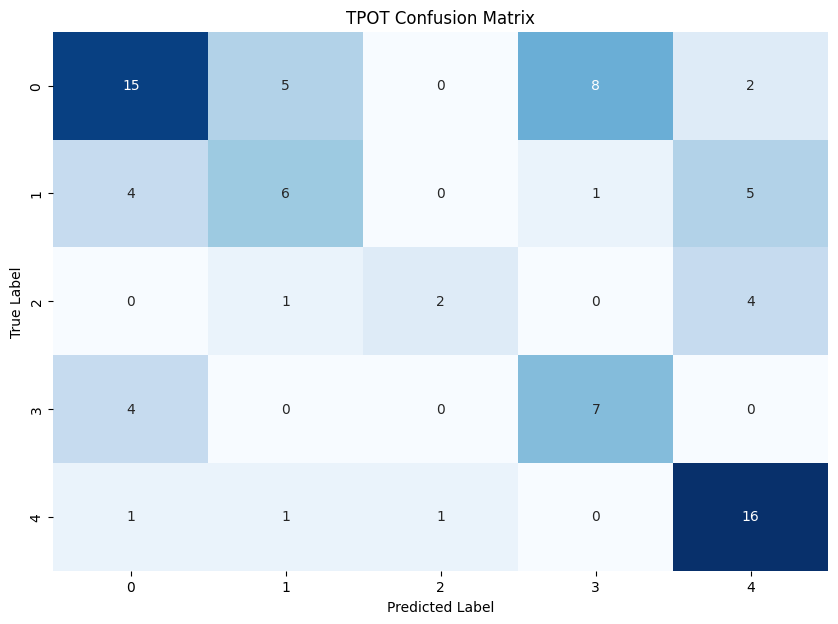

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

###H2O

In [95]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=75633f606631a22c22e4c822b198b15185f4b328eec398145ded03973be94fed
  Stored in directory: /root/.cache/pip/wheels/0c/95/eb/b449c73f478dbc4557b80170cf7f2aa6db15862877e9a63536
Successfully built h2o


In [96]:
import h2o
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [97]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3u5xnjvl
  JVM stdout: /tmp/tmp3u5xnjvl/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3u5xnjvl/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_7ivxj2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [98]:
train = pd.concat([X_train, y_train], axis=1)
train.columns = list(X_train.columns) + ['target']
test = pd.concat([X_test, y_test], axis=1)
test.columns = list(X_test.columns) + ['target']
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [99]:
target = 'target'
features = list(X_train.columns)

In [100]:
aml = H2OAutoML(max_runtime_secs=600, seed=42, verbosity='info')

In [101]:
aml.train(x=features, y=target, training_frame=train_h2o)

AutoML progress: |
16:42:43.825: Project: AutoML_1_20241114_164243
16:42:43.827: 5-fold cross-validation will be used.
16:42:43.833: Setting stopping tolerance adaptively based on the training frame: 0.05
16:42:43.834: Build control seed: 42
16:42:43.837: training frame: Frame key: AutoML_1_20241114_164243_training_Key_Frame__upload_9282471ca005a1f2a08a9a8391fe43dd.hex    cols: 27    rows: 331  chunks: 1    size: 71015  checksum: 2280149362830225326
16:42:43.838: validation frame: NULL
16:42:43.839: leaderboard frame: NULL
16:42:43.839: blending frame: NULL
16:42:43.839: response column: target
16:42:43.839: fold column: null
16:42:43.839: weights column: null
16:42:43.899: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_anne

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [107]:
y_pred_h2o = aml.leader.predict(test_h2o).as_data_frame()['predict']
y_pred_h2o = y_pred_h2o.round().astype(int)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [108]:
accuracy = accuracy_score(y_test, y_pred_h2o)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_h2o))

Test Accuracy: 0.2289156626506024
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.17      0.28        30
           1       0.24      0.38      0.29        16
           2       0.09      0.29      0.13         7
           3       0.04      0.09      0.06        11
           4       0.83      0.26      0.40        19

    accuracy                           0.23        83
   macro avg       0.41      0.24      0.23        83
weighted avg       0.55      0.23      0.27        83



###AutoKeras

In [1]:
!pip install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import autokeras as ak
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

In [10]:
if not tf.config.list_physical_devices('GPU'):
    raise SystemError('GPU device not found. Please ensure CUDA is installed and a compatible GPU is available.')

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [12]:
def extract_coordinates(row):
    x_coords = []
    y_coords = []
    for col in coordinate_columns:
        coord = eval(row[col]) if isinstance(row[col], str) else row[col]
        if isinstance(coord, (list, np.ndarray)) and len(coord) == 2:
            x_coords.append(coord[0])
            y_coords.append(coord[1])
    return pd.Series(x_coords + y_coords)

In [13]:
expanded_data = data.apply(extract_coordinates, axis=1)
expanded_data.columns = [f'{col}_{axis}' for col in coordinate_columns for axis in ['x', 'y']]

# Drop rows with missing values if any were introduced during coordinate extraction
expanded_data.dropna(inplace=True)

In [14]:
y = data.loc[expanded_data.index, 'pose']  # Ensure target is aligned with the filtered features

# Encode target labels as integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(expanded_data, y, test_size=0.2, random_state=42)

In [16]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [17]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

In [21]:
with tf.device('/GPU:0'):
    clf = ak.ImageClassifier(overwrite=True, max_trials=10, seed=42)

In [22]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], 1))

In [ ]:
with tf.device('/GPU:0'):
    clf.fit(X_train, y_train, epochs=50, validation_split=0.2)

Trial 5 Complete [01h 14m 41s]
val_loss: nan

Best val_loss So Far: 1.14984929561615
Total elapsed time: 02h 12m 52s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
True              |True              |image_block_1/normalize
True              |True              |image_block_1/augment
efficient         |efficient         |image_block_1/block_type
global_max        |global_avg        |classification_head_1/spatial_reduction_1/reduction_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
2e-05             |2e-05             |learning_rate
0.1               |0.1               |image_block_1/image_augmentation_1/translation_factor
True              |True              |image_block_1/image_augmentation_1/horizontal_flip
False             |False             |image_block_1/image_augmentation_1/vertical_flip
0.1               |0.1               |image_block_1/image_augmentation_1/rotation_facto

In [ ]:
eval_result = clf.evaluate(X_test, y_test)
print(f"Test Accuracy: {eval_result[1]:.4f}")

# Predict on the test set
y_pred_ak = clf.predict(X_test).flatten()

# Convert predictions to integer labels
y_pred_ak = y_pred_ak.astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_ak)
print("Test Accuracy (manual calculation):", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_ak))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_ak)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('AutoKeras Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()